# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>

### <font color=blue><div align="center">29-02-2024</div></font>

## Modules

In [256]:
# Basic modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random

# Gurobi module
from gurobipy import *

## Data Extraction

In [257]:
# Load the Excel file into a pandas DataFrame


df_21Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [258]:
# Display the DataFrame
df = df_07Nov
df

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,1.0,NaN,NaN,00:55:00
1,2,NaN,1.0,NaN,00:00:00
2,3,1.0,NaN,NaN,01:15:00
3,4,1.0,1.0,NaN,03:15:00
4,5,1.0,NaN,NaN,00:00:00
...,...,...,...,...,...
84,85,NaN,2.0,NaN,00:00:00
85,86,1.0,NaN,1.0,00:00:00
86,87,1.0,NaN,NaN,03:15:00
87,88,2.0,1.0,NaN,00:00:00


The code in the cells below creates a dictionary Passengers defined as follows:

- Passengers Keys: IDs of passengers.
- Passengers Items: For each ID in Passengers, we specify its *type* (female: 0, male: 1, disabled: 2), its *group number*, and its *transit time*.

Notice that for passengers with a transit time equal to 0 or larger than 2 hours, the transit time in the dictionary is set to $\infty$


In [259]:
def convert_TransitTime(time_val):

    # Convert time to minutes
    total_minutes = time_val.hour * 60 + time_val.minute
    
    # Check if total minutes is greater than 2 hours or equal to 0
    if total_minutes > 120 or total_minutes == 0:
        return float('inf')  # Return infinity
    else:
        return total_minutes

df['TransitTime'] = df['TransitTime'].apply(convert_TransitTime)

In [260]:
# Create Passengers dictionary
Passengers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0

transit_times = set()

# Groups : dict[int : List[int]]

Passengers = dict()
i = 1

for group in df.itertuples():
    if not pd.isna(group[2]):
        for k in range(int(group[2])):
            Passengers[i] = {'type': 0, 'group':group[1], 'transit':group[5]}
            number_f += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[3]):
        for k in range(int(group[3])):
            Passengers[i] = {'type': 1, 'group':group[1], 'transit':group[5]}
            number_m += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[4]):
        for k in range(int(group[4])):
            Passengers[i] = {'type': 2, 'group':group[1], 'transit':group[5]}
            number_d += 1
            transit_times.add(group[5])
            i+=1
    
    
Passengers 

{1: {'type': 0, 'group': 1, 'transit': 55.0},
 2: {'type': 1, 'group': 2, 'transit': inf},
 3: {'type': 0, 'group': 3, 'transit': 75.0},
 4: {'type': 0, 'group': 4, 'transit': inf},
 5: {'type': 1, 'group': 4, 'transit': inf},
 6: {'type': 0, 'group': 5, 'transit': inf},
 7: {'type': 0, 'group': 6, 'transit': inf},
 8: {'type': 0, 'group': 6, 'transit': inf},
 9: {'type': 2, 'group': 7, 'transit': inf},
 10: {'type': 0, 'group': 8, 'transit': inf},
 11: {'type': 1, 'group': 8, 'transit': inf},
 12: {'type': 1, 'group': 8, 'transit': inf},
 13: {'type': 1, 'group': 8, 'transit': inf},
 14: {'type': 1, 'group': 8, 'transit': inf},
 15: {'type': 0, 'group': 9, 'transit': inf},
 16: {'type': 0, 'group': 9, 'transit': inf},
 17: {'type': 0, 'group': 9, 'transit': inf},
 18: {'type': 0, 'group': 9, 'transit': inf},
 19: {'type': 0, 'group': 10, 'transit': inf},
 20: {'type': 0, 'group': 11, 'transit': inf},
 21: {'type': 1, 'group': 11, 'transit': inf},
 22: {'type': 0, 'group': 12, 'transit

We define a dictionnary *Groups*, containing as keys the group ID and as valuea, the list of the members of the group

In [261]:
Groups = dict()


for i, passager in Passengers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]

Keys = list(Groups.keys()).copy()


for i in Keys:
        if len(Groups[i]) ==1: del(Groups[i])
Groups

{4: [4, 5],
 6: [7, 8],
 8: [10, 11, 12, 13, 14],
 9: [15, 16, 17, 18],
 11: [20, 21],
 12: [22, 23, 24, 25, 26],
 13: [27, 28, 29, 30],
 14: [31, 32, 33, 34, 35],
 17: [38, 39],
 18: [40, 41, 42, 43, 44],
 20: [46, 47],
 23: [50, 51, 52],
 24: [53, 54, 55, 56],
 26: [58, 59, 60],
 27: [61, 62],
 36: [71, 72],
 38: [74, 75, 76],
 39: [77, 78],
 41: [80, 81],
 42: [82, 83],
 46: [87, 88, 89, 90, 91],
 51: [96, 97],
 57: [103, 104, 105, 106],
 60: [109, 110],
 65: [115, 116, 117, 118],
 67: [120, 121],
 73: [127, 128],
 74: [129, 130, 131],
 75: [132, 133, 134],
 76: [135, 136],
 79: [139, 140],
 81: [142, 143],
 82: [144, 145, 146],
 83: [147, 148, 149],
 84: [150, 151],
 85: [152, 153],
 86: [154, 155],
 88: [157, 158, 159],
 89: [160, 161, 162]}

Definition of parameters necessary for the following steps

In [262]:
weight_f = 70
weight_m = 85
weight_d = 92.5

if sum([4*number_d,number_f,number_m]) <= 174 :
    number_of_rows = 29 #Aircraft model A320
else :
    number_of_rows = 35 #Aircraft model A321

number_of_columns = 7 # adding the aisle


## Model

Defining the relevant variables of the problem

The binary variables $AssignmentVarDict_{i,j,k}$ specify whether the seat located at position $(i,j)$ is occupied by passenger $k$.

In [263]:

m = Model("Seats_Allocation")

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns + 1)
                    for k in range(1, len(Passengers)+1)}

The integer variables $i_{\text{min}}[g]$ and $i_{\text{max}}[g]$ (resp. $j_{\text{min}}[g]$ and $j_{\text{max}}[g]$) give the value
of $i$ (resp. the value of $j$) that is the smallest and the largest \
in group $g$


In [264]:

# Variables i_{min}, i_{max}, j_{min} et j_{max}
i_min = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_rows , name=f'i_min({g})') 
            for g in Groups.keys()}

i_max = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_rows , name=f'i_max({g})') 
            for g in Groups.keys()}

j_min = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_columns , name=f'j_min({g})') 
            for g in Groups.keys()}

j_max = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_columns  , name=f'j_max({g})') 
            for g in Groups.keys()}


### The constraints 

- Constraints related to the definition of variables $i_{\text{min}}[g]$, $i_{\text{max}}[g]$, $j_{\text{min}}[g]$, $j_{\text{max}}[g]$

In [265]:


i_min_Passagers_Group = {(g,p) : m.addConstr(i_min[g] <= quicksum([i*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'i_min_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

i_max_Passagers_Group = {(g,p) : m.addConstr(i_max[g] >= quicksum([i*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'i_max_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

j_min_Passagers_Group = {(g,p) : m.addConstr(j_min[g] <= quicksum([j*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'j_min_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

j_max_Passagers_Group = {(g,p) : m.addConstr(j_max[g] >= quicksum([j*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'j_max_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }


- Every person has one seat

In [266]:
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, number_of_columns + 1) ])
                                                == 1)
                                                for k in range(1,len(Passengers)+1) }

- Every seat is allocated to a single person

In [267]:
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     <=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns+1) }

- Aisle seats are always free

In [268]:
AISLECONSTDIC = { i : m.addConstr(quicksum([AssignmenVarDict[(i,4,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     == 0)
                                                     for i in range(1, number_of_rows + 1)   
}

- Barycenter constraint

In [269]:

i_m = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

i_f = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

i_d = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

j_f = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

j_d = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

In [270]:
IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 5)
JMINBARYCONST = m.addConstr(3 <= j_bary )

- A disabeled person has 4 seats on the aisle side

In [271]:

SeatPer_WCHR_CONST = {k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] 
                                               for i in range(1, number_of_rows ) 
                                               for j in [3, 6] 
                                               ]) == 1, name=f"SeatPerWCHR{k}")
                                               for k in range(1, len(Passengers) + 1)
                                               if Passengers[k]['type'] == 2}

for k in range(1, len(Passengers) + 1):
    if Passengers[k]['type'] == 2:
        for i in range(1, number_of_rows):
            for j in [3, 6]:
                m.addConstr(AssignmenVarDict[(i, j, k)] + quicksum(
                      [AssignmenVarDict[(i, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i}_{j-1}')
                
                m.addConstr(AssignmenVarDict[(i, j, k)] +quicksum(
                      [AssignmenVarDict[(i+1, j, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i+1}_{j}')
                m.addConstr(AssignmenVarDict[(i, j, k)]+ quicksum(
                      [AssignmenVarDict[(i+1, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1,  
                            name=f'Neighbor_WCHR{k}_{i+1}_{j-1}')

## Time Objectif

- Transit time

In [272]:
transit_obj = quicksum( [ AssignmenVarDict[(i,j,k)]* i*(1/Passengers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, number_of_columns+1 )
                      for k in range(1, len(Passengers)+1)
                      if Passengers[k]['transit'] != float('inf') ])

m.setObjective(transit_obj, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

## Optimisation

In [273]:
m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




                                                   z* = 2.63                                                    



In [274]:
z_old = round(transit_obj.getValue(), 2)

- Transit time visualization

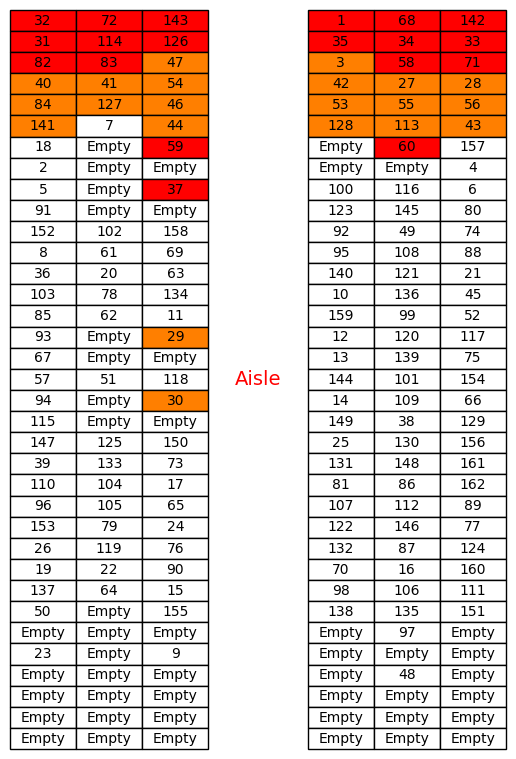

In [275]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]


def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Grouping Objectif

In [276]:

obj_grouping = quicksum([10*(i_max[g] - i_min[g]) + (j_max[g] - j_min[g])
                        for g in Groups.keys()])

m.setObjective(obj_grouping, GRB.MINIMIZE)

m.params.outputflag = 1

m.update()

Set parameter OutputFlag to value 1


## Optimisation


In [277]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change to the desired iteration limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




Set parameter TimeLimit to value 100
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2739 rows, 39846 columns and 653898 nonzeros
Model fingerprint: 0xa2dc190b
Variable types: 0 continuous, 39846 integer (39690 binary)
Coefficient statistics:
  Matrix range     [7e-03, 4e+01]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 2e+01]

Loaded MIP start from previous solve with objective 13494

Presolve removed 204 rows and 6948 columns
Presolve time: 0.83s
Presolved: 2535 rows, 32898 columns, 533311 nonzeros
Variable types: 0 continuous, 32898 integer (32742 binary)
Found heuristic solution: objective 2932.0000000
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barr

- Grouping visualisation

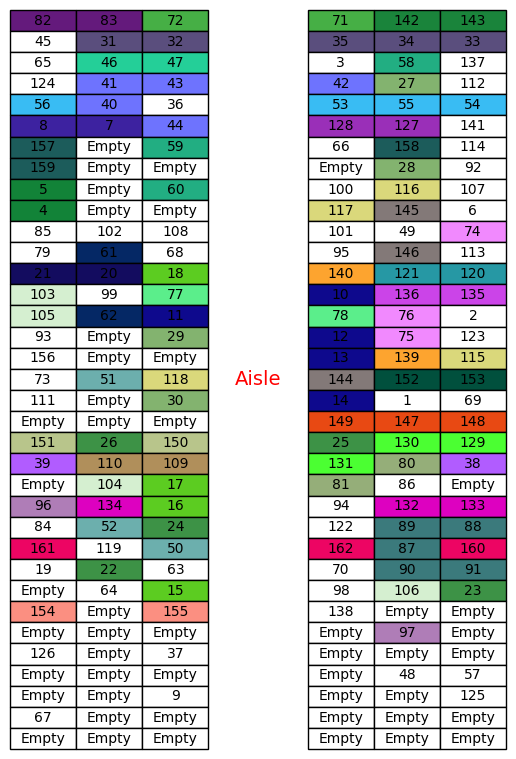

In [278]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = k
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Coupling both objectives

In [279]:
m.setObjective(0.7*obj_grouping + 0.3*transit_obj, GRB.MINIMIZE)

m.params.outputflag = 1

m.update()

## Optimisation

In [280]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change to the desired iteration limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2739 rows, 39846 columns and 653898 nonzeros
Model fingerprint: 0x4defe3ab
Variable types: 0 continuous, 39846 integer (39690 binary)
Coefficient statistics:
  Matrix range     [7e-03, 4e+01]
  Objective range  [4e-03, 7e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 2e+01]

Loaded MIP start from previous solve with objective 863.052



Presolve removed 204 rows and 6948 columns
Presolve time: 1.29s
Presolved: 2535 rows, 32898 columns, 533311 nonzeros
Variable types: 0 continuous, 32898 integer (32742 binary)
Found heuristic solution: objective 862.9083636
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.581e+04
 Factor NZ  : 1.154e+05 (roughly 3 MB of memory)
 Factor Ops : 1.177e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.66913565e+03 -1.06143721e+05  8.60e+03 1.35e-01  1.85e+03     2s
   1   2.59133629e+03 -1.63170969e+05  3.46e+03 3.41e-13  6.74e+02     2s
   2   9.09739845e+02 -1.22888702e+05  4.22e+02 6.25e-13  9.12e+01     2s
   3   8.16766757e+02 -1.01080994e+05  1.21e+02 5.68e-13  3.37e+01     2s
   4   6.47124631e+02 -1.0174126

- Transit time visualisation

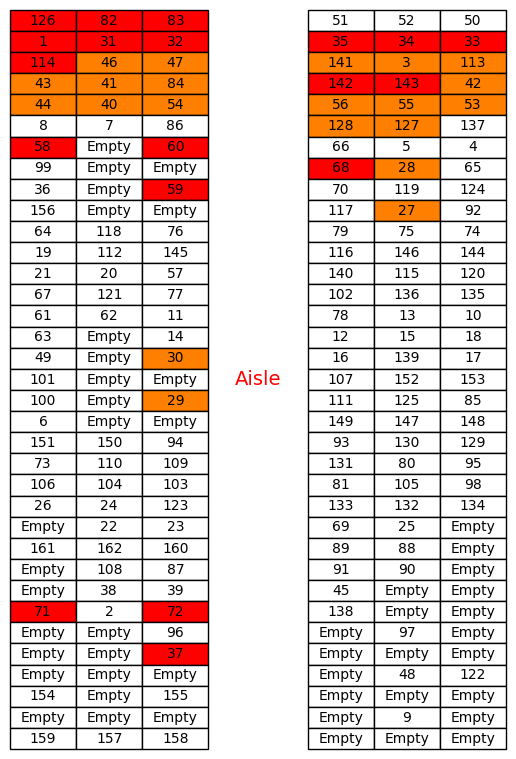

In [281]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]


def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Disabled visualization

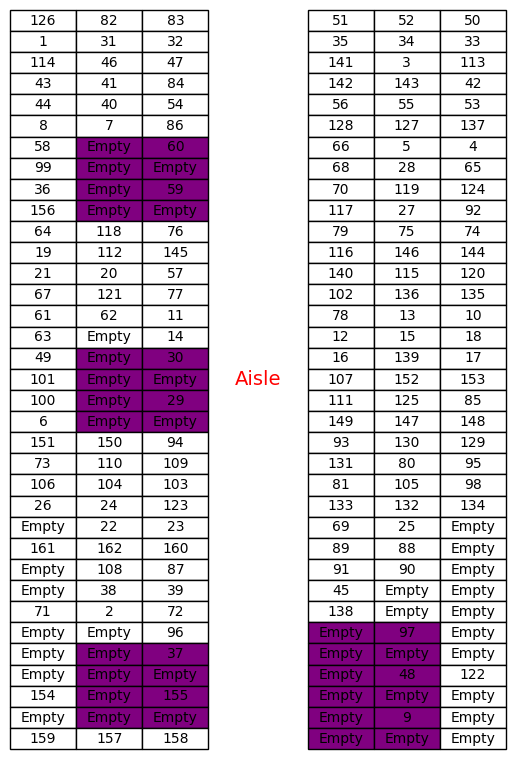

In [282]:

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['type']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passengers[k]['type']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Groups vizualisation

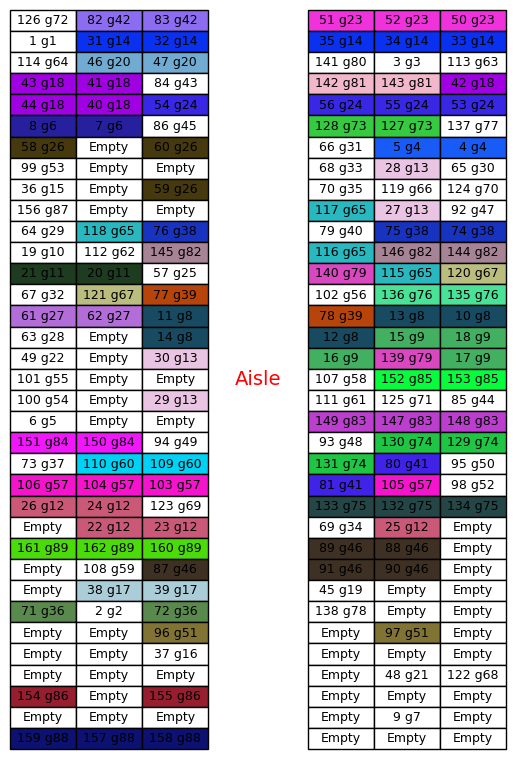

In [283]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Metrics

- Transit metric

In [284]:

z_new = round(transit_obj.getValue(), 2)


print("The satisfaction level related to transit time:", (1- (z_new- z_old)/z_old) * 100, " %" )

The satisfaction level related to transit time: 34.60076045627377  %


- Grouping metric

In [285]:
# Définition des constantes pour les niveaux de satisfaction
SATISFIED = 1.0
MEDIUM_SATISFIED = 0.5
NOT_SATISFIED = 0.0

# Initialisation des variables pour les scores de satisfaction
satisfaction_scores = []

for group, passengers in Groups.items():
    print(passengers)
    for pass_id in passengers:
        seat_positions = [(i, j) for i in range(1, number_of_rows+1)
                            for j in range(1, number_of_columns+1)
                            if AssignmenVarDict.get((i, j, pass_id), 0).x == 1]
        if seat_positions:  # Vérifie si la liste n'est pas vide
            seat_position = seat_positions[0]  # Prend le premier élément
            print(f"** Le passager {pass_id} est assis à la position {seat_position}")
        else:
            print(f"Aucun siège trouvé pour le passager {pass_id}. Vérifiez l'indexation et les données.")
            
        i, j = seat_position
        neighbors = [(i, j-1), (i, j+1)]
        satisfaction = 0
        for neighbor in neighbors:
            ni, nj = neighbor
            if 1 <= nj <= number_of_columns:
                if nj == 4 or j == 4:  # S'ils sont séparés par l'allée, attribuez MEDIUM_SATISFIED seulement si dans la même rangée
                    if any(AssignmenVarDict.get((ni, nj, other_pass_id), 0).x == 1 for other_pass_id in passengers if other_pass_id != pass_id):
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, Medium")
                        satisfaction = max(satisfaction, MEDIUM_SATISFIED)
                elif nj != 4:
                    if any(AssignmenVarDict.get((ni, nj, other_pass_id), 0).x == 1 for other_pass_id in passengers if (other_pass_id != pass_id and ni == i)):
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, True")
                        satisfaction = max(satisfaction, SATISFIED)
                    else :
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, False")
                        satisfaction = max(satisfaction, NOT_SATISFIED)
        satisfaction_scores.append(satisfaction)
        print(f"** Passager {pass_id} -- satisfaction {satisfaction}\n")

for pass_id in range(1, len(Passengers) + 1):
    if all(pass_id not in passengers for _, passengers in Groups.items()):
        # Ce passager est seul
        # print(f"Le passager {pass_id} est seul et est automatiquement SATISFIED.")
        satisfaction_scores.append(SATISFIED)

# Calcul du score de groupement moyen (pourcentage de satisfaction)
grouping_score = sum(satisfaction_scores) / len(satisfaction_scores)

# Retourner le score de groupement en pourcentage
grouping_score_percentage = grouping_score * 100
grouping_score_percentage


[4, 5]
** Le passager 4 est assis à la position (7, 7)
Pass 4, Seat (7, 7), Neighbor (7, 6), True
** Passager 4 -- satisfaction 1.0

** Le passager 5 est assis à la position (7, 6)
Pass 5, Seat (7, 6), Neighbor (7, 5), False
Pass 5, Seat (7, 6), Neighbor (7, 7), True
** Passager 5 -- satisfaction 1.0

[7, 8]
** Le passager 7 est assis à la position (6, 2)
Pass 7, Seat (6, 2), Neighbor (6, 1), True
Pass 7, Seat (6, 2), Neighbor (6, 3), False
** Passager 7 -- satisfaction 1.0

** Le passager 8 est assis à la position (6, 1)
Pass 8, Seat (6, 1), Neighbor (6, 2), True
** Passager 8 -- satisfaction 1.0

[10, 11, 12, 13, 14]
** Le passager 10 est assis à la position (15, 7)
Pass 10, Seat (15, 7), Neighbor (15, 6), True
** Passager 10 -- satisfaction 1.0

** Le passager 11 est assis à la position (15, 3)
Pass 11, Seat (15, 3), Neighbor (15, 2), False
** Passager 11 -- satisfaction 0

** Le passager 12 est assis à la position (16, 5)
Pass 12, Seat (16, 5), Neighbor (16, 6), False
** Passager 1

76.5432098765432